# 权重衰减

权重衰减是最广泛使用的正则化的技术之一

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline
from d2l import mindspore as d2l
from mindspore import nn, Parameter, value_and_grad, mint
from mindspore.common.initializer import Normal
import numpy as np

[WARNING] CORE(258524,ffffbb590640,python):2025-12-14-22:02:25.082.874 [mindspore/core/utils/ms_context.cc:533] GetJitLevel] Set jit level to O2 for rank table startup method.
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/python3.10.14/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'n

像以前一样生成一些数据
$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2)$$

In [3]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = np.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

初始化模型参数

In [4]:
def init_params():
    w = Parameter(d2l.normal((num_inputs, 1), 0, 1), name='w')
    b = Parameter(d2l.zeros(1), name='b')
    return [w, b]

定义$L_2$范数惩罚

In [5]:
def l2_penalty(w):
    return mint.sum(d2l.pow(w, 2)) / 2

定义训练代码实现

In [6]:
def train(lambd):
    w, b = init_params()
    net, loss_fn = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    optim = d2l.SGD(lr, batch_size, [w, b])
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])

    # 定义前向传播函数
    def forward_fn(x, y):
        z = net(x)
        loss = loss_fn(z, y) + lambd * l2_penalty(w)
        return loss

    # 获取梯度函数
    grad_fn = value_and_grad(forward_fn, None, weights=[w, b])

    # 定义模型单步训练 
    def train_one_step(X, Y):
        loss, grads = grad_fn(X, Y)
        optim(grads)
        return loss

    for epoch in range(num_epochs):
        for X, y in train_iter.create_tuple_iterator():
            l = train_one_step(X, y)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter.create_tuple_iterator(), loss_fn),
                                     d2l.evaluate_loss(net, test_iter.create_tuple_iterator(), loss_fn)))
    print('w的L2范数是：', d2l.norm(w).asnumpy())

忽略正则化直接训练

.w的L2范数是： 14.9913225


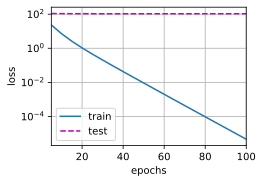

In [7]:
train(lambd=0)

使用权重衰减

w的L2范数是： 0.3492763


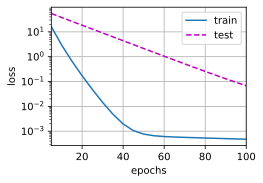

In [8]:
train(lambd=3)

简洁实现

In [9]:
def train_concise(wd):
    net = nn.SequentialCell([nn.Dense(num_inputs, 1, weight_init=Normal(1, 0))])
    loss_fn = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # mindspore的SGD不支持对单个parameter做weight_decay
    optim = nn.SGD(net.trainable_params(), learning_rate=lr, weight_decay=wd)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])

    # 定义前向传播函数
    def forward_fn(x, y):
        z = net(x)
        loss = loss_fn(z, y).mean()
        return loss

    # 获取梯度函数
    grad_fn = value_and_grad(forward_fn, None, weights=net.trainable_params())

    # 定义模型单步训练
    def train_one_step(X, Y):
        loss, grads = grad_fn(X, Y)
        optim(grads)
        return loss

    for epoch in range(num_epochs):
        for X, y in train_iter.create_tuple_iterator():
            l = train_one_step(X, y)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter.create_tuple_iterator(), loss_fn),
                                     d2l.evaluate_loss(net, test_iter.create_tuple_iterator(), loss_fn)))
    print('w的L2范数：', d2l.norm(net[0].weight).asnumpy())

这些图看起来和我们从零开始实现权重衰减时的图相同

.w的L2范数： 12.6534


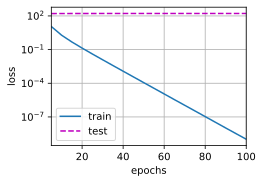

In [10]:
train_concise(0)

w的L2范数： 0.35079002


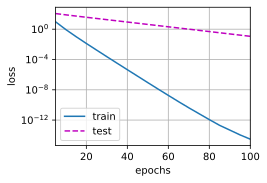

In [11]:
train_concise(3)